Дан датасет с ответами сотрудников на вопросы «Соответствуют ли выполняемые задачи Вашим интересам и ожиданиям» и «Соответствует ли содержание и уровень задач ожиданиям». Нужно научиться определять к какой категории отнести тот или иной ответ.

Набор данных состоит из 1254 ответов сотрудников.

К классу 0 отнесем задачи, которые соответствуют ожиданиям и интересам сотрудников;

К классу 1 отнесем следующие ответы: 

- задачи скорее соответствуют, чем нет;

- средне;

- скорее не соответствуют, чем да;

- не соответствует;

- непонятныю.й ответ/не знаю.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import sklearn
import matplotlib
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold

from wordcloud import WordCloud

import torch
import transformers
import torch.nn as nn
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from bert_model import BERT_Arch


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

import pymorphy3

import nltk

import warnings
warnings.filterwarnings('ignore')

from joblib import dump


C:\Users\User\anaconda3\envs\MyEnv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


Загрузим данные и посмотрим на размер предварительно размеченного датасета.

In [4]:
df = pd.read_csv('res.csv', index_col=[0])
print(df.head())
print(df.shape)

                                           TEXTVALUE  Label
0  Задачи на проекте действительно очень интересн...    0.0
1  Иногда приходят задачи которые выше моих знани...    1.0
2                                      Соответствует    0.0
3                                         Да, вполне    0.0
4                                      Соответствуют    0.0
(1254, 2)


In [5]:
df['Label'][134]=1.0

In [6]:
df.loc[134]

TEXTVALUE    Выполняемые задачи полностью соответствуют мои...
Label                                                      1.0
Name: 134, dtype: object

Удаляю ненужные '\n'

In [7]:
for i in range(len(df)):
  df['TEXTVALUE'][i] = df['TEXTVALUE'][i].replace('\n', "")

Посмотрим на расспределение классов.

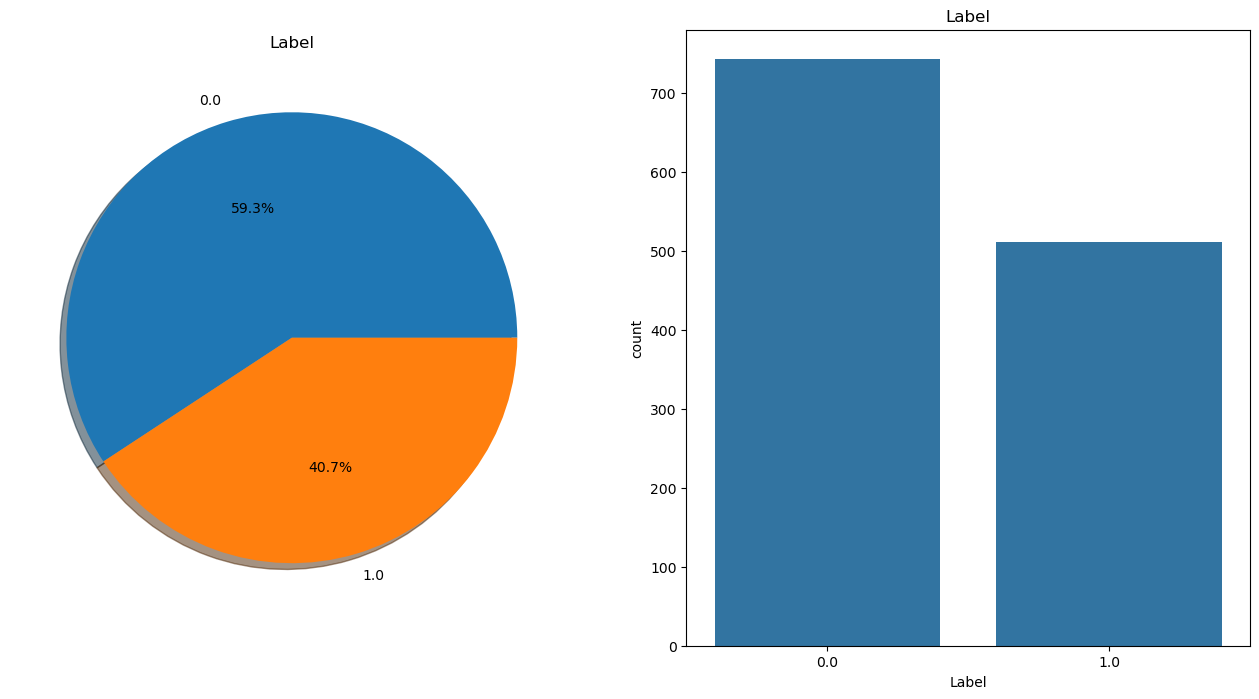

In [8]:
f,ax=plt.subplots(1,2,figsize=(16,8))
df['Label'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Label')
ax[0].set_ylabel('')
sns.countplot(df, x = 'Label', ax=ax[1])
ax[1].set_title('Label')
plt.show()

Виден явный дисбаланс классов. Преобладают положительные ответы сотрудников с оправданными ожиданиями.

Построим облако слов, чтобы увидеть наиболее часто встречаемые слова.

In [9]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud)
    plt.axis("off")

def wordcloud_params(text_raw):
  ru_stopwords = set(stopwords.words('russian')) - {'да','нет'}
  wordcloud = WordCloud(width = 2000,
                        height = 1500,
                        random_state=1,
                        background_color='black',
                        margin=10,
                        colormap='Pastel1',
                        collocations=False,
                        stopwords = ru_stopwords).generate(text_raw)

  return wordcloud

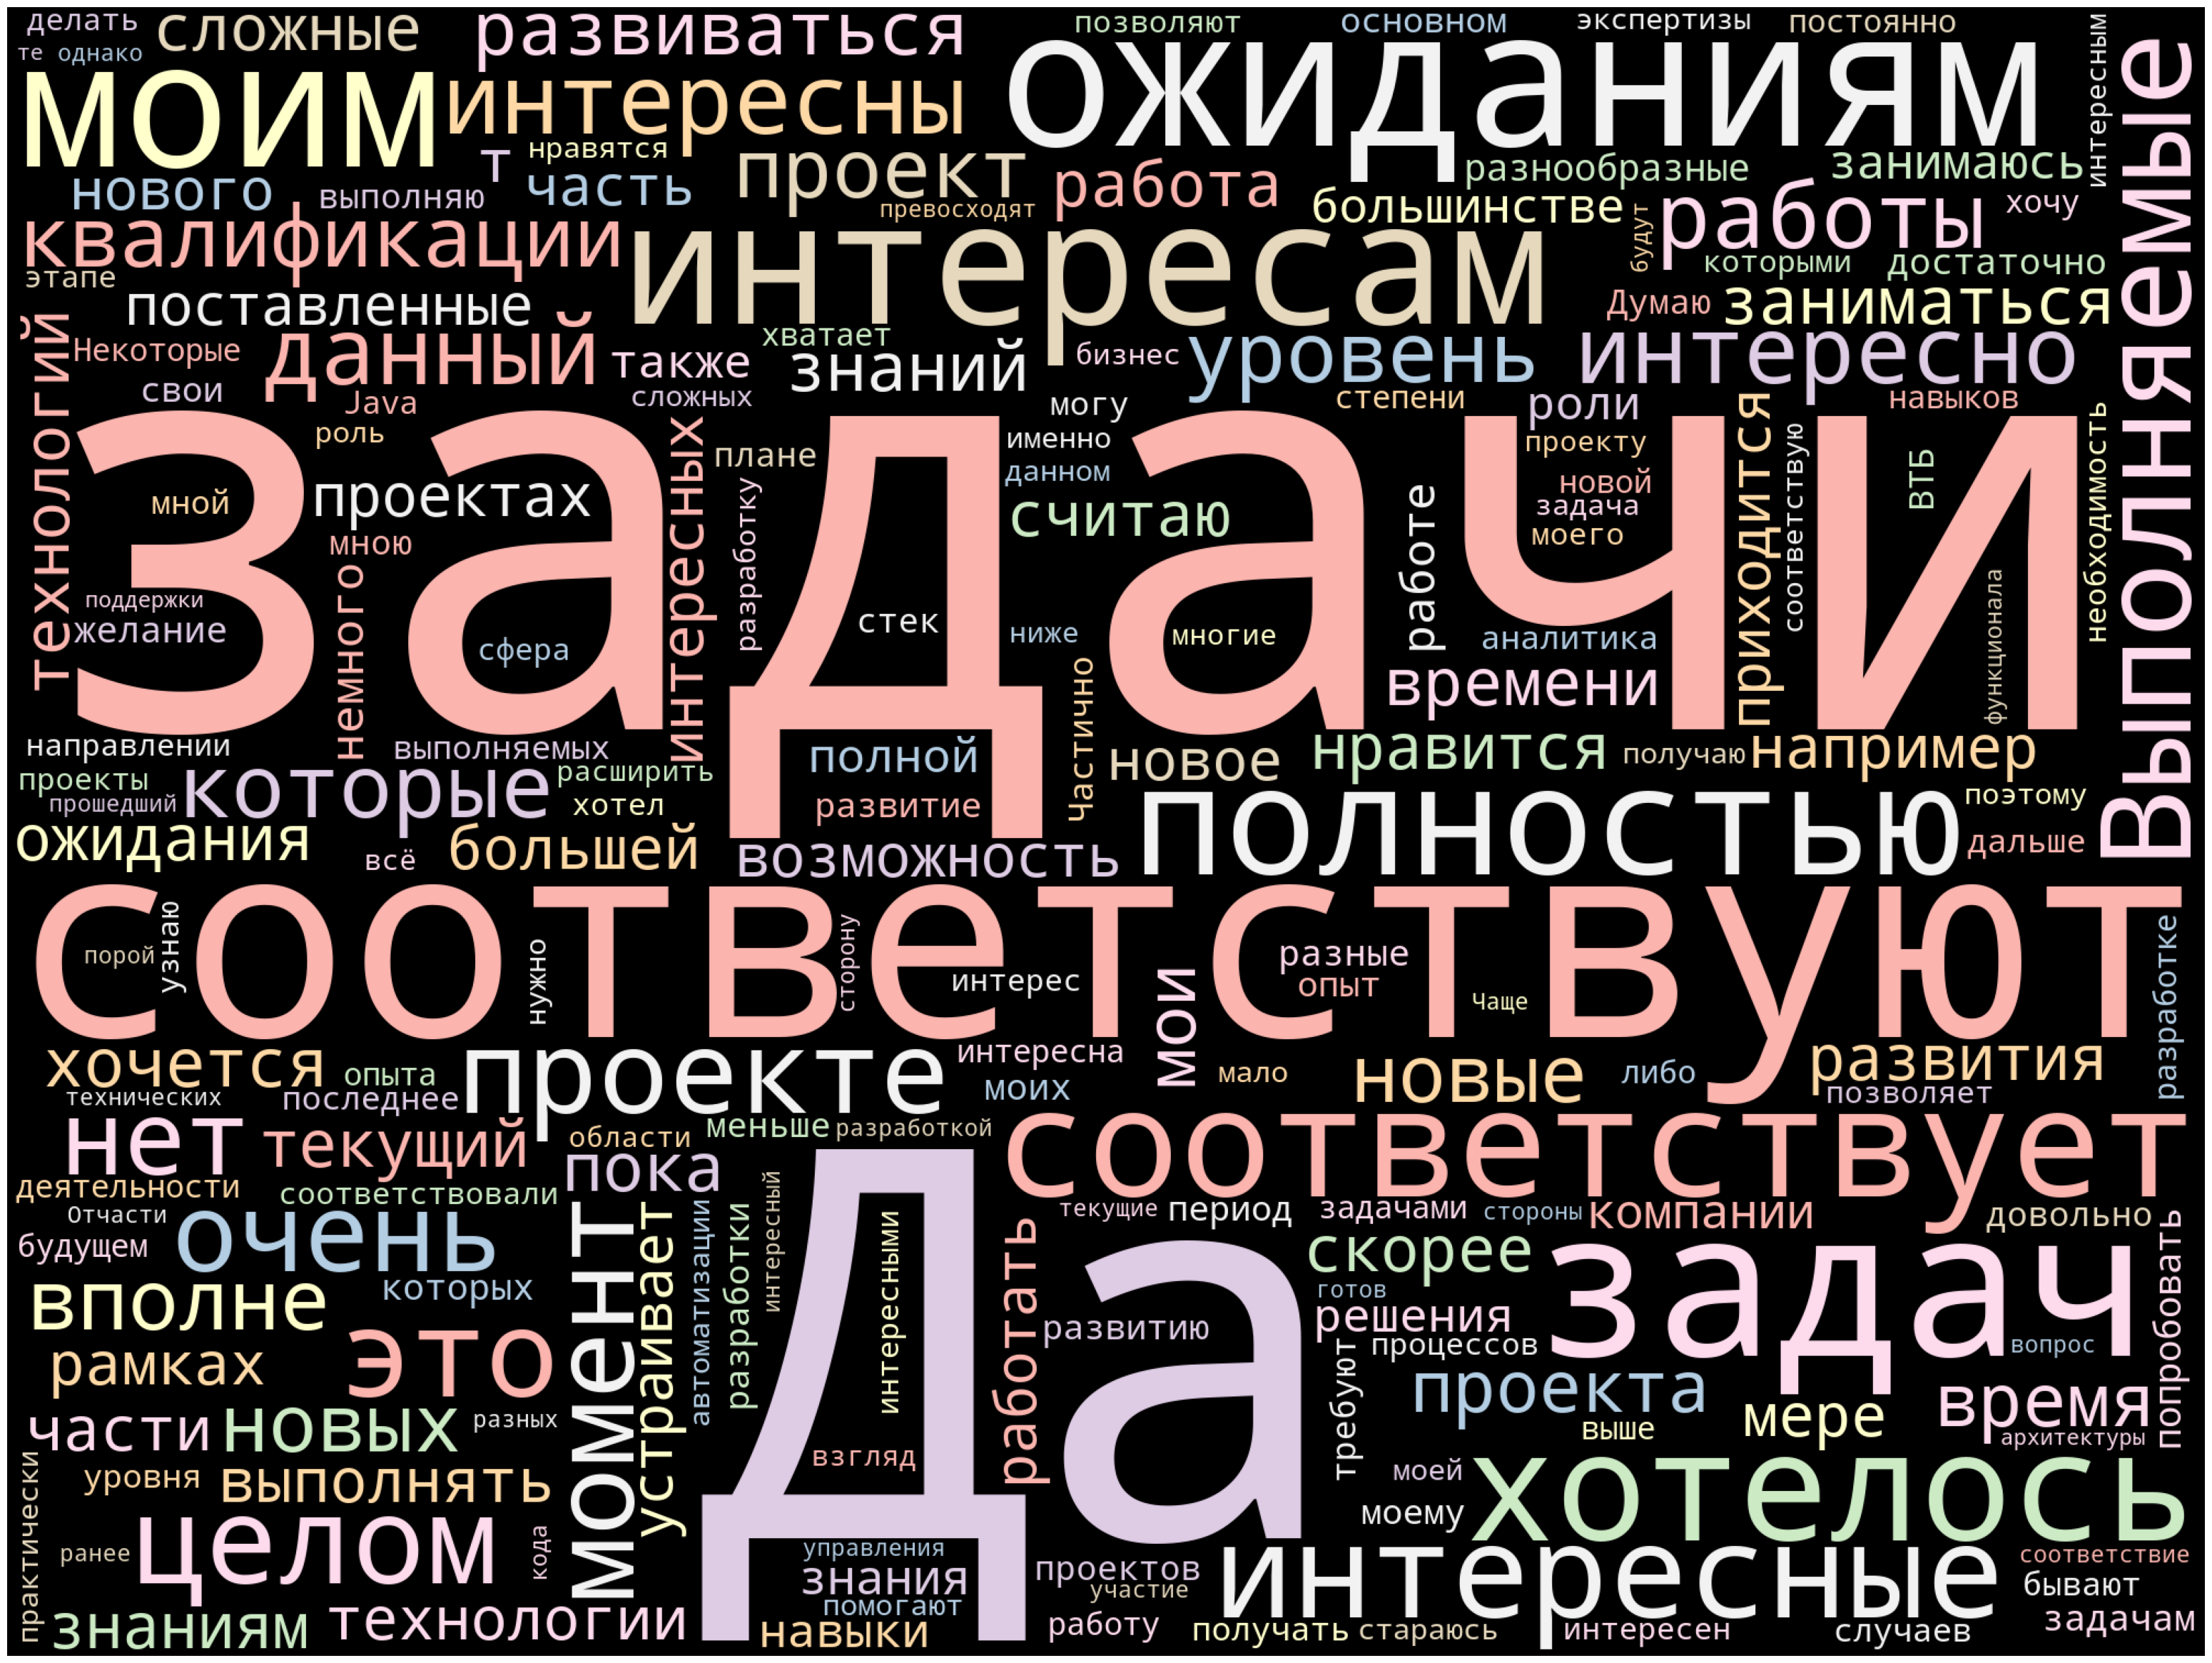

In [10]:
text_raw = " ".join(df['TEXTVALUE'])
plot_cloud(wordcloud_params(text_raw))

Построим облако слов для каждого класса

(-0.5, 1999.5, 1499.5, -0.5)

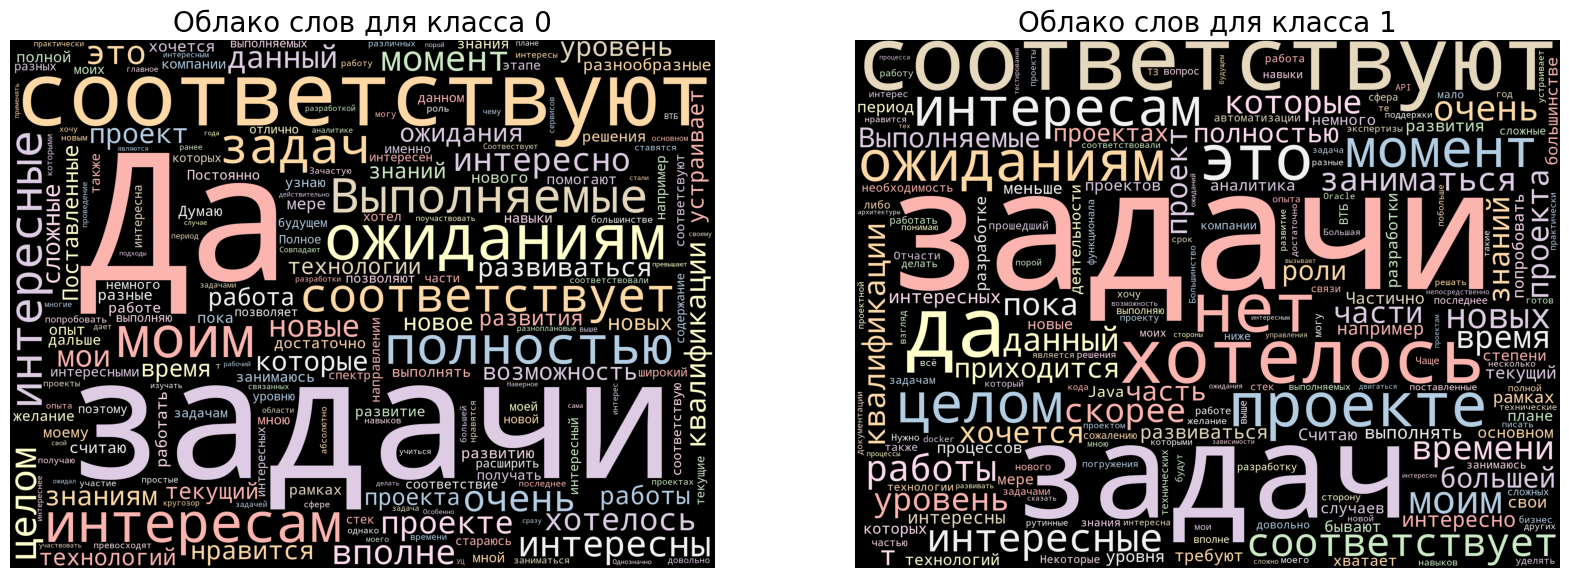

In [11]:
f,ax=plt.subplots(1,2,figsize=(20,10))
text_raw = " ".join(df[df['Label']==0]['TEXTVALUE'])
wordcloud = wordcloud_params(text_raw)
ax[0].imshow(wordcloud)
ax[0].set_title('Облако слов для класса 0', fontsize=20)
ax[0].axis('off')

text_raw = " ".join(df[df['Label']==1]['TEXTVALUE'])
wordcloud = wordcloud_params(text_raw)
ax[1].imshow(wordcloud)
ax[1].set_title('Облако слов для класса 1', fontsize=20)
ax[1].axis('off')

Во всех облаках слов наиболее часто встречаемое слово задачи, также часто встречаются "соответствуют", "да" и др. Возможно для более лучшей производительности модели стоит использовать метод извлечения признаков, учитывающий контекст слова в документе.

Построим график распределения токенов по документам

Text(0.5, 0, 'Кол-во токенов')

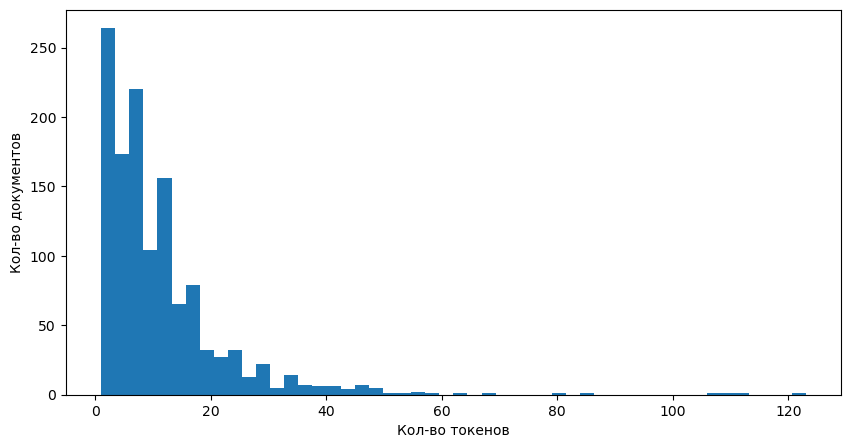

In [12]:
def count_token(a):
  return len(a.split())

df['TEXTVALUE'].apply(lambda doc: count_token(doc)).hist(grid = False, figsize = (10, 5), bins=50)
plt.ylabel('Кол-во документов')
plt.xlabel('Кол-во токенов')

Видно, что преобладают короткие документы, примерно до 15 токенов

Осуществляю предобработку текста. Заменяю знаки препинания на пробел, привожу все символы к нижнему регистру, разбиваю строку на части, привожу к стемовской форме, убираю стоп-слова, конвертирую текст в векторы, в каждом из которых подсчитывается частота встречаемости слова в документе, с помощью мешка слов.

In [13]:
df['Label'].fillna(4, inplace=True)
#Предобработка текста

morph = pymorphy3.MorphAnalyzer()
corpus = []


for i in range(len(df)):
    #заменяет символ из не содержащегося в [^a-zA-z], т.е. знаки препинания
    #на пробел ' '
    rev = re.sub('[^\w\s]',' ',df['TEXTVALUE'][i])
    #функция lower() возвращает копию строки, в которой все символы в нижнем регистре.
    rev = rev.lower()
    #split Разбивает строку на части, используя разделитель, и возвращает эти части списком.
    #Направление разбиения: слева направо.
    rev = rev.split()



    #Привожу к стемовской форме и убираю стоп-слова

    new_stopwords = set(stopwords.words('russian')) - {'да','нет'}

    rev = [morph.parse(word)[0].normal_form for word in rev if word not in new_stopwords]
    rev = ' '.join(rev)
    corpus.append(rev)


Tfidf_vector = TfidfVectorizer(ngram_range=(2, 2))

Tfidf = Tfidf_vector.fit_transform(corpus)

count_vectorizer = CountVectorizer()

bag_of_words = count_vectorizer.fit_transform(corpus)
feature_names = count_vectorizer.get_feature_names_out()
pd.DataFrame(bag_of_words.toarray(), columns = feature_names)

0а  10  100  10практически  135  155  2018  2019  2020  22  ...  \
0      0   0    0              0    0    0     0     0     0   0  ...   
1      0   0    0              0    0    0     0     0     0   0  ...   
2      0   0    0              0    0    0     0     0     0   0  ...   
3      0   0    0              0    0    0     0     0     0   0  ...   
4      0   0    0              0    0    0     0     0     0   0  ...   
...   ..  ..  ...            ...  ...  ...   ...   ...   ...  ..  ...   
1249   0   0    0              0    0    0     0     0     0   0  ...   
1250   0   0    0              0    0    0     0     0     0   0  ...   
1251   0   0    0              0    0    0     0     0     0   0  ...   
1252   0   0    0              0    0    0     0     0     0   0  ...   
1253   0   0    0              0    0    0     0     0     0   0  ...   

      эскалировать  этап  это  этот  эффективный  явление  являться  явный  \
0                0     0    0     0            0        0         0      0   
1                0     0    0     0            0        0         0      0   
2                0     0    0     0            0        0         0      0   
3                0     0    0     0            0        0         0      0   
4                0     0    0     0            0        0         0      0   
...            ...   ...  ...   ...          ...      ...       ...    ...   
1249             0     0    0     0            0        0         0      0   
1250             0     0    1     0            0        0         0      0   
1251             0     0    0     0            0        0         0      0   
1252             0     0    0     0            0        0         0      0   
1253             0     0    0     0            0        0         0      0   

      язык  ящик  
0        0     0  
1        0     0  
2        0     0  
3        0     0  
4        0     0  
...    ...   ...  
1249     0     0  
1250     0     0  
1251     0     0  
1252     0     0  
1253     0     0  

[1254 rows x 1813 columns]

In [14]:
X = corpus
Y = df['Label']


In [15]:
bert = AutoModel.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

In [16]:
DF = df.copy()

In [17]:
DF['Label'].value_counts()

Label
0.0    743
1.0    511
Name: count, dtype: int64

In [18]:
for i in range(len(DF)):
  DF['TEXTVALUE'][i] = DF['TEXTVALUE'][i].replace('\n', "")

Разобьем данные на тестовую и обучающую выборки

In [19]:
X = DF['TEXTVALUE']
Y = DF['Label']

X_train , X_test_val , Y_train , Y_test_val = train_test_split(X,Y,test_size=0.4,random_state=42, stratify=Y)
X_test , X_val , Y_test , Y_val = train_test_split(X_test_val,Y_test_val,test_size=0.5,random_state=42, stratify=Y_test_val)

In [21]:
tokens_train = tokenizer.batch_encode_plus(
    X_train,
    max_length = 15,
    padding = 'max_length',
    truncation = True
)

tokens_val = tokenizer.batch_encode_plus(
    X_val,
    max_length = 15,
    padding = 'max_length',
    truncation = True
)

tokens_test = tokenizer.batch_encode_plus(
    X_test,
    max_length = 15,
    padding = 'max_length',
    truncation = True
)

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(Y_train.values)

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(Y_val.values)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(Y_test.values)
batch_size = 8

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

val_data =  TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)

In [19]:
for param in bert.parameters():
    param.requires_grad = False

In [20]:
model = BERT_Arch(bert)

model = model.to(device)
from transformers import AdamW

optimizer = AdamW(model.parameters(),
               lr= 1e-3)

Для борьбы с дисбалансом применяю взвешивание классов

In [21]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight = 'balanced', classes=np.unique(Y_train), y=Y_train)

print(class_weights)

weights = torch.tensor(class_weights, dtype = torch.float)
weights = weights.to(device)
cross_entropy = nn.CrossEntropyLoss()
epochs = 20

[0.84304933 1.22875817]


In [22]:
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []
    
    for step, batch in enumerate(train_dataloader):
        batch = [r.to(device) for r in batch]
        sent_id,mask,labels = batch
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels.type(torch.LongTensor))
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)
        
    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    
    return avg_loss, total_preds

In [23]:
def evaluate():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []

    for step, batch in enumerate(val_dataloader):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels.type(torch.LongTensor))
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    avg_loss = total_loss / len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)

    return avg_loss, total_preds

In [25]:
best_valid_loss = float('inf')

train_losses = []
valid_losses = []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))
    
    train_loss, _ = train()
    valid_loss, _ = evaluate()
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')


 Epoch1 / 20

Training loss: 0.512
Validation loss: 0.516

 Epoch2 / 20

Training loss: 0.448
Validation loss: 0.577

 Epoch3 / 20

Training loss: 0.455
Validation loss: 0.497

 Epoch4 / 20

Training loss: 0.439
Validation loss: 0.531

 Epoch5 / 20

Training loss: 0.447
Validation loss: 0.540

 Epoch6 / 20

Training loss: 0.453
Validation loss: 0.508

 Epoch7 / 20

Training loss: 0.434
Validation loss: 0.445

 Epoch8 / 20

Training loss: 0.413
Validation loss: 0.554

 Epoch9 / 20

Training loss: 0.415
Validation loss: 0.509

 Epoch10 / 20

Training loss: 0.429
Validation loss: 0.569

 Epoch11 / 20

Training loss: 0.394
Validation loss: 0.478

 Epoch12 / 20

Training loss: 0.401
Validation loss: 0.487

 Epoch13 / 20

Training loss: 0.394
Validation loss: 0.483

 Epoch14 / 20

Training loss: 0.377
Validation loss: 0.549

 Epoch15 / 20

Training loss: 0.395
Validation loss: 0.487

 Epoch16 / 20

Training loss: 0.360
Validation loss: 0.520

 Epoch17 / 20

Training loss: 0.380
Validation l

Text(0.5, 0, 'Epoches')

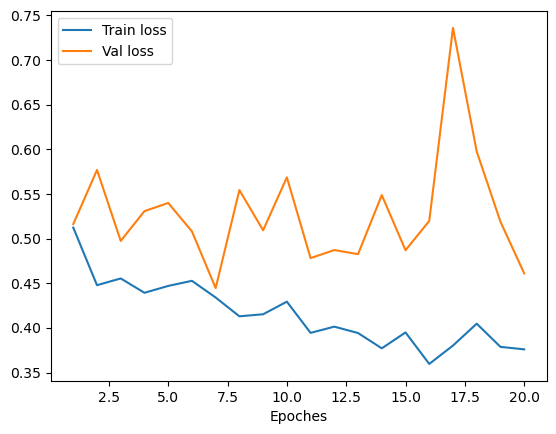

In [26]:
plt.plot(np.arange(1, 21, 1), train_losses) 
plt.plot(np.arange(1, 21, 1), valid_losses)
plt.legend(['Train loss', 'Val loss'])
plt.xlabel('Epoches')

In [27]:
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [28]:
#dump(model, 'model.joblib', compress=9)

['model.joblib']

In [82]:
import gc
gc.collect()
torch.cuda.empty_cache()

list_seq = np.array_split(test_seq, 50)
list_mask = np.array_split(test_mask, 50)


predictions = []
for num, elem in enumerate(list_seq):
    with torch.no_grad():
        preds = model(elem.to(device), list_mask[num].to(device))
        predictions.append(preds.detach().cpu().numpy())

In [83]:
all_predictions = np.concatenate(predictions, axis=0)

predicted_classes = np.argmax(all_predictions, axis=1)
true_labels = Y_test.values  

In [84]:
predicted_classes

array([0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0], dtype=int64)

In [86]:
y_test = Y_test

In [87]:
print(classification_report(y_test, predicted_classes, zero_division = 0))

              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83       149
         1.0       0.75      0.75      0.75       102

    accuracy                           0.80       251
   macro avg       0.79      0.79      0.79       251
weighted avg       0.80      0.80      0.80       251



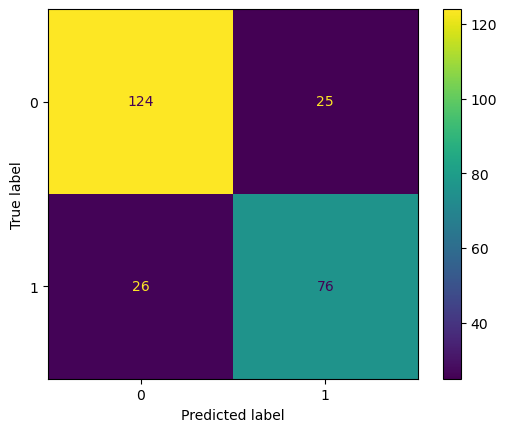

In [88]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, predicted_classes, labels=np.unique(predicted_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=np.unique(predicted_classes))
disp.plot()

plt.show()